# Assignment Ch. 5 - Transfer Learning [Case #2]
Startup Campus, Indonesia - `Artificial Intelligence Track`
* Dataset: MNIST Handwritten Digits (10 classes)
* Libraries: PyTorch, Torchvision, Scikit-learn
* Objective: Transfer Learning using CNN-based Pre-trained Models

`PREREQUISITE` All modules (with their suitable versions) are installed properly.
<br>`TASK` Complete the notebook cell's code marked with <b>#TODO</b> comment.
<br>`TARGET PORTFOLIO` Students are able to:
* implement transfer learning technique using various PyTorch pre-trained models, and
* examine the effect of freezing some parts of the layer.

<br>`WARNING` Do **NOT CHANGE** any codes within the User-defined Functions (UDFs) section.

### Case Study Description
A new robotic facility located in East Kalimantan, near the Titik Nol Ibu Kota Negara (IKN) Indonesia, asks you to create a Computer Vision model for their new droid (robot) products. The company requests you to **teach the robot how to read a sequence of numbers**. You suddenly realize that the first stage is to let the robot correctly identify each individual digit (0-9). However, since the prototype announcement date was hastened, your deadline is very tight: you only have **less than 1 week** to complete the job. As a professional AI developer, you keep calm and know that you can exploit the **Transfer Learning** method to solve this problem efficiently.

As a basic dataset in most of Computer Vision tasks, **Modified National Institute of Standards and Technology (MNIST) database** contains 10 handwritten digits. All of them are in the grayscale (1-channel). Torchvision, a sub-library of PyTorch, has dozens of pre-trained models that you can easily choose from. All of these models were originally trained on the ImageNet dataset [(ref1)](https://www.image-net.org/download.php), which contains millions of RGB (3-channel) images and 1,000 classes. For simplicity, let choose **Resnet18** [(ref2)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf), **DenseNet121** [(ref3)](https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf), and **Vision Transformer (ViT)** [(ref4)](https://arxiv.org/pdf/2010.11929.pdf) as baseline, state-of-the-art models to test the **image classification** performance. Your complete tasks are as follows.

1. Pick **DenseNet** as your first model to experiment with, then **change the number of neurons in the first and last layers** (since the ImageNet has 1,000 classes, while MNIST only has 10 classes; both are also come with different image size and channel).
2. Define **hyperparameters** and train the model (all **layers are trainable**).
3. Plot the model performance, for both **training** and **validation** results.
4. Now try to **freeze (layers are non-trainable) some parts** of layers: (1) "denseblock1", (2) "denseblock1" and "denseblock2". These will be two separate models.
5. **Retrain** each model, plot its performance, and examine the difference.
6. BONUS: Can you **replicate** all of the steps above with different models, i.e., **ResNet** and **ViT**?

### Import libraries

In [ ]:
import torch, torchvision, time
from numpy.random import seed
from tqdm.autonotebook import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy
from warnings import filterwarnings as fw; fw("ignore")

<ipython-input-1-5061f0ddd5d4>:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
torch.__version__ #== "2.0.1+cu117"

'2.0.1+cu118'

In [ ]:
torchvision.__version__ #== "0.15.2+cu117"

'0.15.2+cu118'

In [ ]:
#!pip install update torch torchvision -U

In [ ]:
# define seeding
seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True

### User-defined Functions (UDFs)

- To print total model parameters

In [ ]:
def check_params(model, *args, **kwargs) -> dict:
    return {
        "total_trainable_params" : sum(p.numel() for p in model.parameters() if p.requires_grad),
        "total_nontrainable_params" : sum(p.numel() for p in model.parameters() if not p.requires_grad)
    }

- To get the pair of train and validation dataloaders

In [ ]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
])

train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform, download=True).train_data.float()

def get_dataloaders(train_batch_size : int, val_batch_size : int, max_rows : int = 1000, *args, **kwargs) -> tuple:
    data_transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((torch.tensor(33.3184)/255,), (torch.tensor(78.5675)/255,))
    ])

    train_dataset = torchvision.datasets.MNIST(root=".", train=True, transform=data_transform)
    train_idx = torch.randperm(len(train_dataset))[:int(max_rows*.75)]
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, \
                                               sampler=torch.utils.data.SubsetRandomSampler(train_idx))

    val_dataset = torchvision.datasets.MNIST(root=".", train=False, transform=data_transform)
    val_idx = torch.randperm(len(val_dataset))[:int(max_rows*.25)]
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=val_batch_size, \
                                             sampler=torch.utils.data.SubsetRandomSampler(val_idx))

    return train_loader, val_loader

100%|██████████| 9912422/9912422 [00:00<00:00, 113734366.05it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23286369.44it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25394141.91it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16725661.78it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



* To fit (training) the model

In [ ]:
def fit(
    model : torchvision.models,
    epoch : int,
    train_loader : torch.utils.data.DataLoader,
    val_loader : torch.utils.data.DataLoader,
    *args, **kwargs
) -> dict:

    TRAIN_LOSS, TRAIN_ACC = [], []
    train_batches = len(train_loader)

    VAL_LOSS, VAL_ACC = [], []
    val_batches = len(val_loader)

    # loop for every epoch (training + evaluation)
    start_ts = time.time()
    for e in range(epoch):
        train_losses = 0
        train_accuracies = 0

        # progress bar
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batches)

        # ----------------- TRAINING  --------------------
        # set model to training
        model.train()

        for i, data in progress:
            X, y = data[0].to(device), data[1].to(device)

            # training step for single batch
            model.zero_grad()

            # forward pass
            outputs = model(X)
            loss = loss_function(outputs, y)

            # backward pass
            loss.backward()
            optimizer.step()

            train_losses += loss.item()

            ps = torch.exp(outputs)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == y.view(*top_class.shape)
            train_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

            # updating progress bar
            progress.set_description("Loss: {:.4f}".format(train_losses/(i+1)))

        TRAIN_ACC.append(train_accuracies/train_batches)
        TRAIN_LOSS.append(train_losses/train_batches)

        # releasing unceseccary memory in GPU
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----------------- VALIDATION  -----------------
        val_losses = 0
        val_accuracies = 0

        # set model to evaluating (testing)
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                X, y = data[0].to(device), data[1].to(device)
                outputs = model(X) # this gives the prediction from the network
                val_losses += loss_function(outputs, y).item()

                ps = torch.exp(outputs)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == y.view(*top_class.shape)
                val_accuracies += torch.mean(equals.type(torch.FloatTensor)).item()

        print("Epoch {}/{} >> Training loss: {:.3f}, Validation loss: {:.3f}, Validation accuracy: {:.3f}".format(
            e+1, epoch, train_losses/train_batches, val_losses/val_batches, val_accuracies/val_batches*100)
        )

        VAL_ACC.append(val_accuracies/val_batches)
        VAL_LOSS.append(val_losses/val_batches)

    tr_time = time.time()-start_ts
    print("Training time: {:.3f}s".format(tr_time))

    return {
        "model" : model.name,
        "train_acc" : TRAIN_ACC,
        "train_loss" : TRAIN_LOSS,
        "val_acc" : VAL_ACC,
        "val_loss" : VAL_LOSS,
        "exc_time" : tr_time
    }

* To visualize the model performance

In [ ]:
def plot_performance(dict_ : dict, *args, **kwargs) -> None:
    my_figure = plt.figure(figsize=(12, 4))
    # NOTE: figsize=(width/horizontally, height/vertically)

    m = my_figure.add_subplot(121)
    plt.plot(dict_["train_loss"], label="Train Loss")
    plt.plot(dict_["val_loss"], label="Valid. Loss")
    plt.title("LOSS")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    n = my_figure.add_subplot(122)
    plt.plot(dict_["train_acc"], label="Train Accuracy")
    plt.plot(dict_["val_acc"], label="Valid. Accuracy")
    plt.title("ACCURACY")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

### Define the model class

In [ ]:
class VisionModel(torch.nn.Module):
    def __init__(self, model_selection : str, *args, **kwargs) -> None:
        super(VisionModel, self).__init__()
        self.model_selection = self.name = model_selection
        self.in_channels = 1

        def create_conv2d(this_layer, *args, **kwargs) -> torch.nn.modules.conv.Conv2d:
            return torch.nn.Conv2d(
                in_channels=self.in_channels, out_channels=this_layer.out_channels,
                kernel_size=this_layer.kernel_size, stride=this_layer.stride,
                padding=this_layer.padding, bias=this_layer.bias
            )

        if not self.model_selection.lower() in ["resnet", "densenet", "vit"]:
            raise ValueError("Please select the model: 'resnet', 'densenet', or 'vit'.")

        if self.model_selection == "resnet":
            self.model = torchvision.models.resnet18(pretrained=True)
            self.model.conv1 = create_conv2d(self.model.conv1) # change the input layer to take Grayscale image, instead of RGB
            self.model.fc = torch.nn.Linear(self.model.fc.in_features, 10) # change the output layer to output 10 classes

        elif self.model_selection == "densenet":
            self.model = torchvision.models.densenet121(pretrained=True)
            self.model.features.conv0 = create_conv2d(self.model.features.conv0)
            self.model.classifier = torch.nn.Linear(self.model.classifier.in_features, 10)

        elif self.model_selection == "vit":
            self.model = torchvision.models.vit_b_16(pretrained=True)
            self.model.conv_proj = create_conv2d(self.model.conv_proj)
            self.model.classifier = torch.nn.Linear(self.model.heads.head.in_features, 10)

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, data, *args, **kwargs) -> torchvision.models:
        x = self.model(data)
        return self.softmax(x)

### Set device to CUDA

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

### Define hyperparameters

In [ ]:
EPOCH = 5
BATCH_SIZE = 6
LEARNING_RATE = 1e-5

### Define the model

In [ ]:
model = VisionModel("densenet").to(device)
check_params(model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 182MB/s] 


{'total_trainable_params': 6957834, 'total_nontrainable_params': 0}

In [ ]:
model

VisionModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0

### WILL BE USED LATER: Freeze some layers

In [ ]:
model_freeze_block1 = deepcopy(model)
for name, param in model_freeze_block1.named_parameters():
    if param.requires_grad and "denseblock1" in name:
        param.requires_grad = False
check_params(model_freeze_block1)

{'total_trainable_params': 6622794, 'total_nontrainable_params': 335040}

In [ ]:
model_freeze_block12 = deepcopy(model)
for name, param in model_freeze_block12.named_parameters():
    if param.requires_grad and any([x in name for x in ["denseblock1", "denseblock2"]]):
        param.requires_grad = False
check_params(model_freeze_block12)

{'total_trainable_params': 5703114, 'total_nontrainable_params': 1254720}

### Get train and validation dataloaders

To speedup the training time, we will only use 1,000 (of 60,000) images from MNIST.

In [ ]:
train_loader, val_loader = get_dataloaders(BATCH_SIZE, BATCH_SIZE)
len(train_loader), len(val_loader)

(125, 42)

### Set loss function and model optimizer

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

trainable_model_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

### Start the model training

In [ ]:
results = fit(model=model, epoch=EPOCH, train_loader=train_loader, val_loader=val_loader)

Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.234, Validation loss: 2.152, Validation accuracy: 46.825


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.109, Validation loss: 1.999, Validation accuracy: 75.198


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 1.964, Validation loss: 1.832, Validation accuracy: 86.706


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 1.830, Validation loss: 1.731, Validation accuracy: 87.897


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 1.748, Validation loss: 1.659, Validation accuracy: 90.873
Training time: 71.144s


In [ ]:
results

{'model': 'densenet',
 'train_acc': [0.2706666715145111,
  0.5613333370685577,
  0.7586666648387909,
  0.8399999971389771,
  0.8826666612625123],
 'train_loss': [2.2342661418914793,
  2.1090705785751345,
  1.9640024824142457,
  1.830434482574463,
  1.748065203666687],
 'val_acc': [0.4682539729844956,
  0.7519841272206533,
  0.8670634854407537,
  0.8789682501838321,
  0.9087301535265786],
 'val_loss': [2.151775978860401,
  1.9988361171313695,
  1.831530062925248,
  1.730831966513679,
  1.6591588599341256],
 'exc_time': 71.14386320114136}

### Plot the model performance

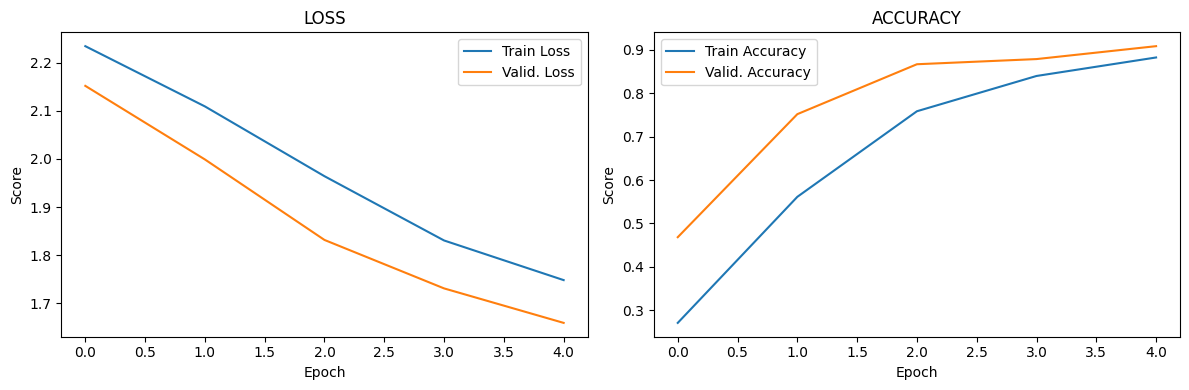

In [ ]:
plot_performance(results)

### NEXT ROUND: Retrain the model with frozen layers

In [ ]:
FROZEN_RESULTS = []
for idx, m in enumerate([model_freeze_block1, model_freeze_block12]):
    print("id: {}".format(idx))
    trainable_model_params = [p for p in m.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_model_params, lr=LEARNING_RATE)

    new_results = fit(model=m, epoch=EPOCH, train_loader=train_loader, val_loader=val_loader)
    FROZEN_RESULTS.append(new_results)

id: 0


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.244, Validation loss: 2.158, Validation accuracy: 51.786


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.105, Validation loss: 2.016, Validation accuracy: 72.421


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 1.974, Validation loss: 1.860, Validation accuracy: 80.952


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 1.855, Validation loss: 1.754, Validation accuracy: 84.127


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 1.771, Validation loss: 1.696, Validation accuracy: 85.913
Training time: 56.445s
id: 1


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5 >> Training loss: 2.249, Validation loss: 2.172, Validation accuracy: 45.238


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/5 >> Training loss: 2.134, Validation loss: 2.049, Validation accuracy: 72.619


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/5 >> Training loss: 2.014, Validation loss: 1.900, Validation accuracy: 81.548


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/5 >> Training loss: 1.875, Validation loss: 1.766, Validation accuracy: 83.929


Loss:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/5 >> Training loss: 1.787, Validation loss: 1.706, Validation accuracy: 84.325
Training time: 54.109s


### Examine the difference in both accuracy and loss

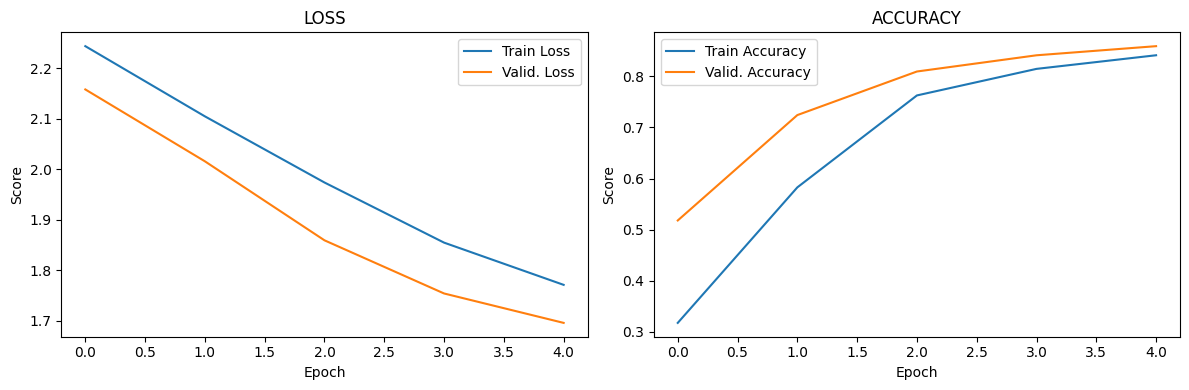

In [ ]:
plot_performance(FROZEN_RESULTS[0])

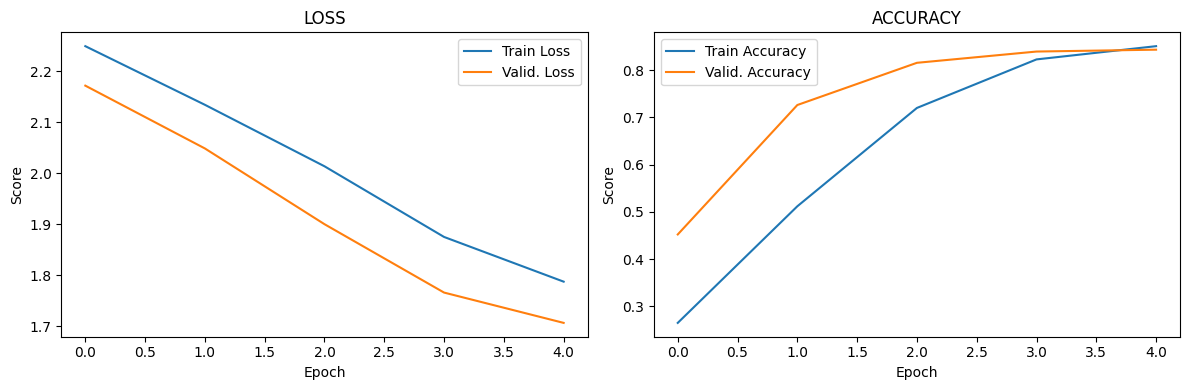

In [ ]:
plot_performance(FROZEN_RESULTS[1])

In [ ]:
# QUESTIONS
# TODO: With the same 5 epochs in training, why Transfer Learning with frozen layers are worse in the final accuracy?

it seems to me that when using transfer learning with frozen layers, the pre-drilling model has a number of layers that are assumed to understand the general features of the data. And we only train on a few layers of data so it can lead to lower final accuracy in some situations, especially when you have little training data. By freezing the deepest layers, the model may not have the flexibility to change its internal representation to suit more specific tasks.

In [ ]:
# QUESTIONS
# TODO: Why the more layers are frozen, the lower the accuracy of the model in the early (the 1st) epoch?

Because, freezing more layers during training means they are not updated with new data, as more layers are frozen, thereby skipping frozen layers. while freezing some layers can be beneficial, freezing too many can also lead to lower accuracy.

In short, freezing too many layers will limit the model's ability to adapt, recognize new patterns, and capture task-specific features, leading to lower accuracy, especially in the early training period.

### Examine the difference in the execution time

In [ ]:
print("When all layers were TRAINABLE: {:.3f}s.".format(results["exc_time"]))
print("Only 'denseblock1' was FROZEN: {:.3f}s.".format(FROZEN_RESULTS[0]["exc_time"]))
print("Only 'denseblock1' and 'denseblock2' wwere FROZEN: {:.3f}s.".format(FROZEN_RESULTS[1]["exc_time"]))

When all layers were TRAINABLE: 71.144s.
Only 'denseblock1' was FROZEN: 56.445s.
Only 'denseblock1' and 'denseblock2' wwere FROZEN: 54.109s.


In [ ]:
# QUESTIONS
# TODO: Why the more layers are frozen, the faster the training-validation time?

Freezing more layers during training can result in faster training validation times due to reduced computational complexity and memory requirements. Frozen layers significantly reduce the number of parameters that need to be updated, therefore, frozen layers can improve training validation time, because in the model training procedures have been skipped when the model has more frozen layers

### Scoring
Total `#TODO` = 12
<br>Checklist:

- [ ] Change the DenseNet input layer stack by calling create_conv2d()
- [ ] Change the DenseNet output layer with 10 classes
- [ ] Change the ViT input layer stack by calling create_conv2d()
- [ ] Change the ViT output layer with 10 classes
- [ ] Define the batch size
- [ ] Define the learning rate
- [ ] Define the loss function (for multi-classification)
- [ ] Pass the string "resnet" for ResNet18, "densenet" for DenseNet121, and "vit" for Vision Transformer
- [ ] Specify variables for your model, number of epochs, train data loader, and validation data loader
- [ ] QUESTION: With the same 5 epochs in training, why Transfer Learning with frozen layers are worse in the final accuracy?
- [ ] QUESTION: Why the more layers are frozen, the lower the accuracy of the model in the early (the 1st) epoch?
- [ ] QUESTION: Why the more layers are frozen, the faster the training-validation time?

### Additional readings
* ResNet: https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
* DenseNet: https://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf
* Vision Transformer (ViT): https://arxiv.org/pdf/2010.11929.pdf
* MNIST Classification w/ PyTorch (Beginner): https://www.kaggle.com/code/amsharma7/mnist-pytorch-for-beginners-detailed-desc

### Copyright © 2023 Startup Campus, Indonesia
* You may **NOT** use this file except there is written permission from PT. Kampus Merdeka Belajar (Startup Campus).
* Please address your questions to mentors.